In [1]:
# This is the same generator as in 02 DCGAN (from the DCGAN Paper)
# Discriminator
import torch
import torch.nn as nn

class Discriminator(nn.Module): # aka. Critic
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x Channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(
                features_d, features_d * 2, kernel_size=4, stride=2, padding=1
            ),  # 16x16
            self._block(
                features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1
            ),  # 8x8
            self._block(
                features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1
            ),  # 4x4
            nn.Conv2d(
                features_d * 8, 1, kernel_size=4, stride=2, padding=0
            ),  # 1x1 Single Return Value
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        # DC GAN => Conv Layer, Batch Norm, Leaky ReLU
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
          # Input: N x z_dim x 1 x 1
					self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
					self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
					self._block(features_g*8, features_g*4, 4 ,2 ,1), # 16x16
					self._block(features_g*4, features_g*2, 4 ,2 ,1), # 32x32
					nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # 64x64
					nn.Tanh(), # [-1,1]
				)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
     return self.gen(x) 

def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight, 0.0, 0.02)
      
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1 ,1)
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  
test()

In [2]:
# Helper Functions
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def img(img, e, i):
  img = img.cpu().numpy()
  plt.figure(figsize=(25, 25))
  plt.title(f"Epoch {e}, Batch {i}")
  plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest', cmap="gray")
  plt.savefig(f"image/{e}_{i}.png")
  plt.show()
  
def show_images(fake, e, batch_idx):
  img_grid_fake = torchvision.utils.make_grid(
		fake, normalize=True, padding=5
	)
  img(img_grid_fake, e + 1, batch_idx)

  0%|          | 0/5 [00:05<?, ?e/s, lossC=-.082, lossG=0.0114]

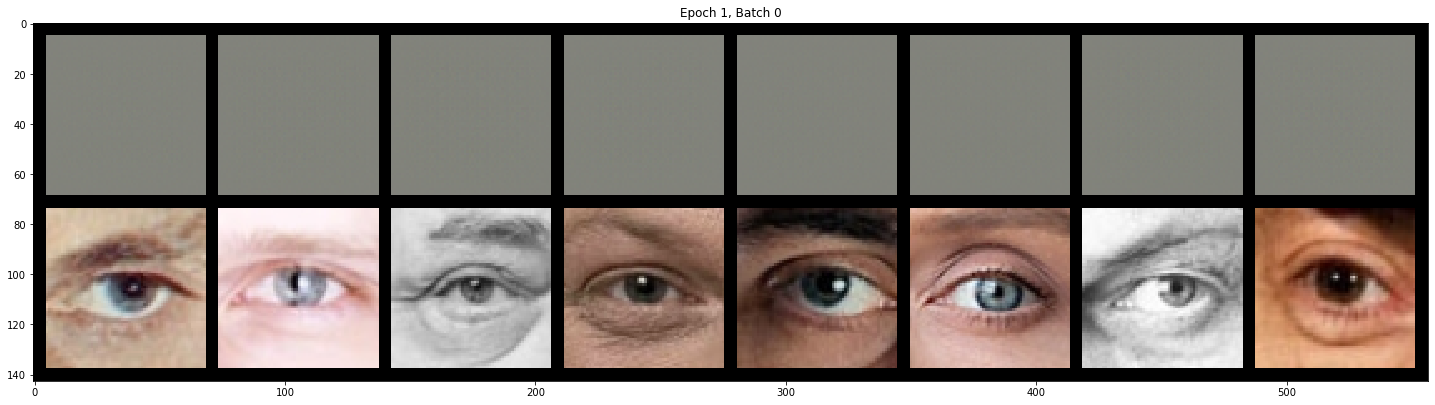

  0%|          | 0/5 [00:52<?, ?e/s, lossC=-1.52, lossG=0.706] 

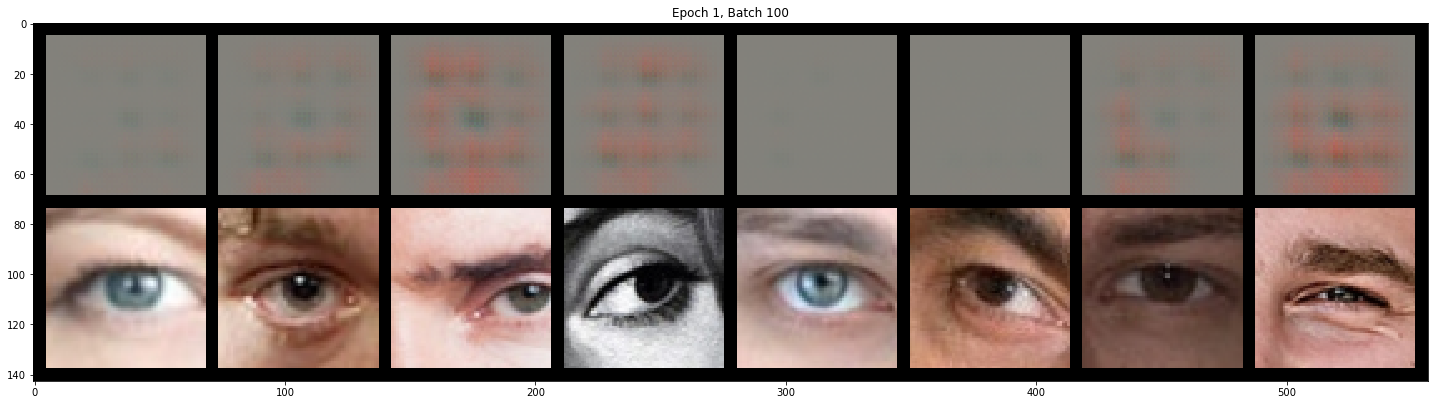

 20%|██        | 1/5 [01:29<05:55, 88.99s/e, lossC=-1.52, lossG=0.709]

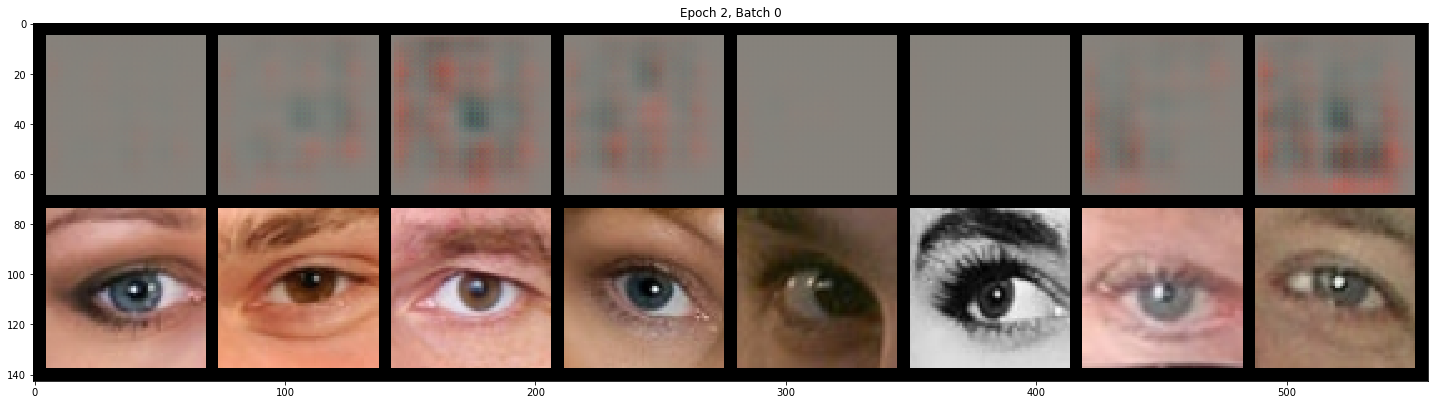

 20%|██        | 1/5 [02:14<05:55, 88.99s/e, lossC=-1.53, lossG=0.709]

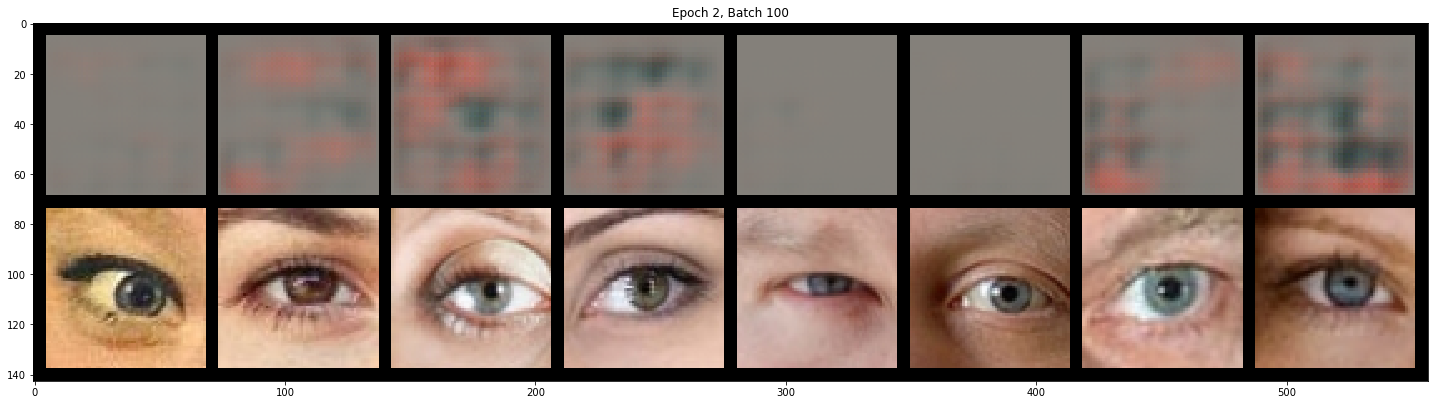

 40%|████      | 2/5 [02:53<04:18, 86.05s/e, lossC=-1.53, lossG=0.711]

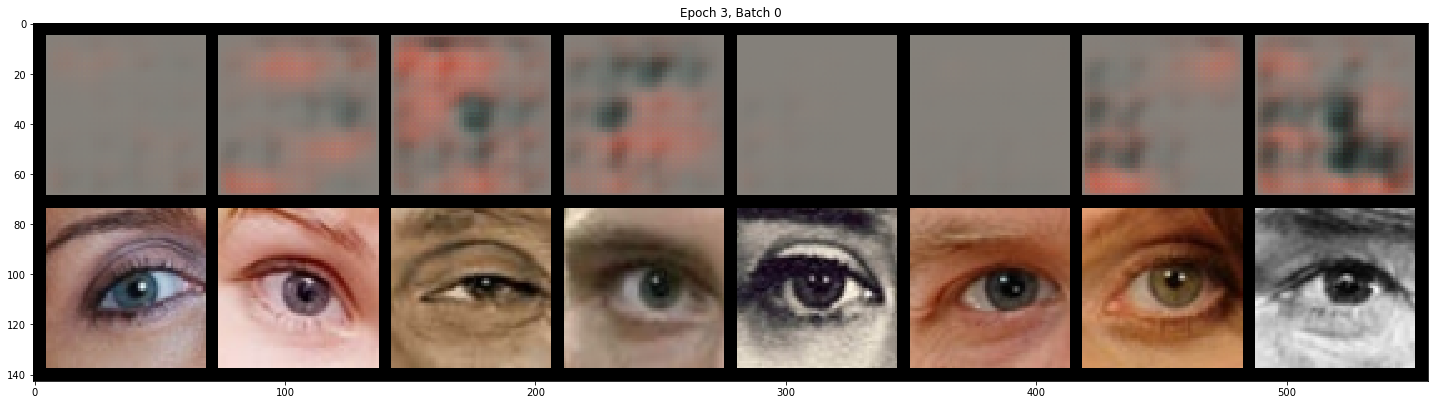

 40%|████      | 2/5 [03:38<04:18, 86.05s/e, lossC=-1.53, lossG=0.71] 

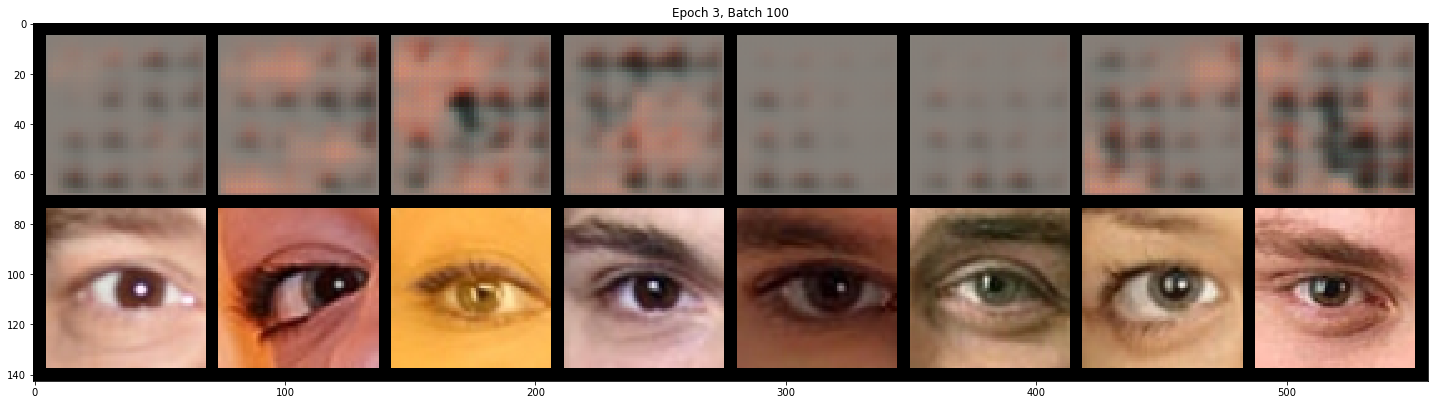

 60%|██████    | 3/5 [04:15<02:48, 84.22s/e, lossC=-1.53, lossG=0.711]

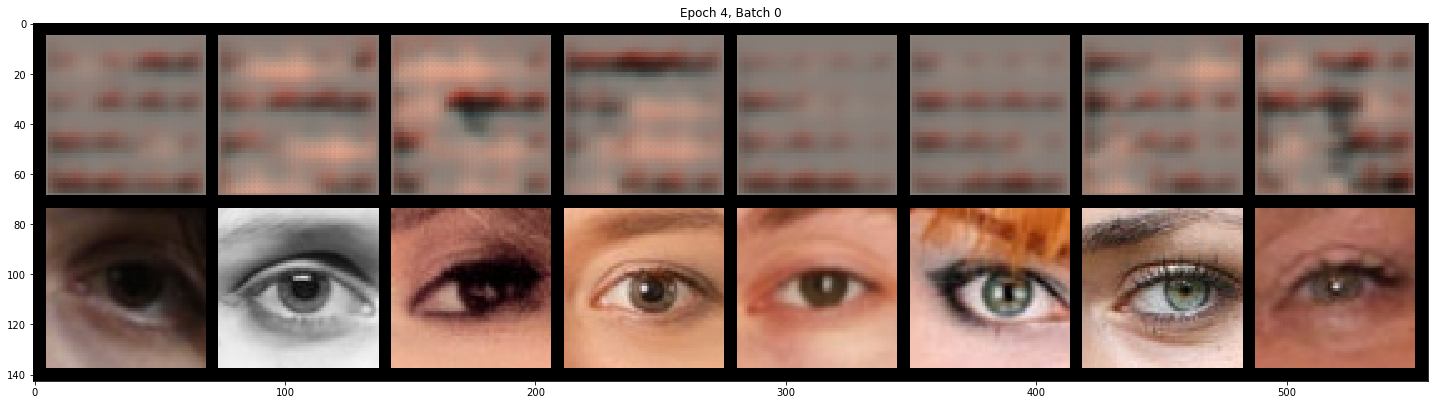

 60%|██████    | 3/5 [05:02<02:48, 84.22s/e, lossC=-1.5, lossG=0.692] 

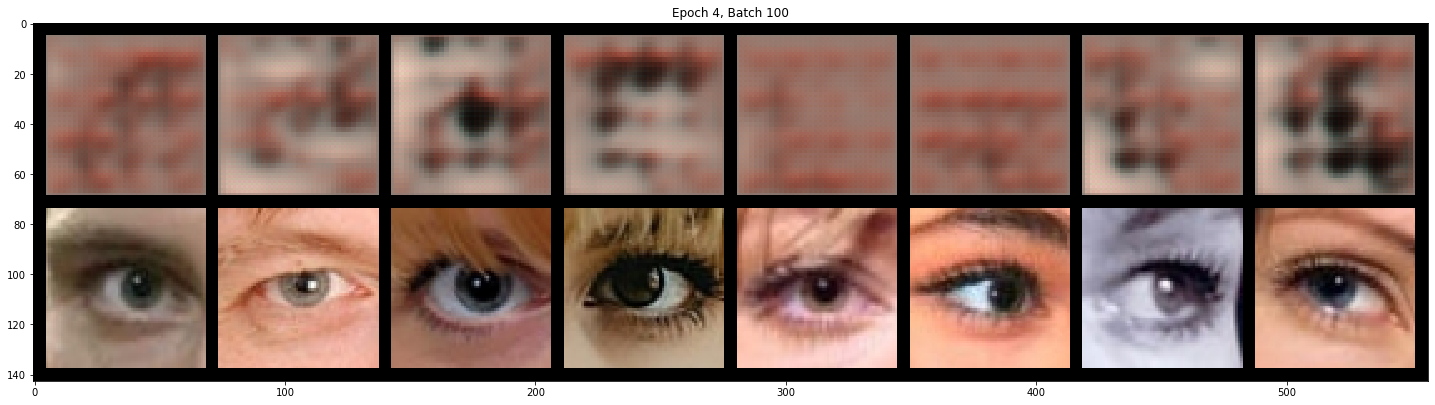

 80%|████████  | 4/5 [05:29<01:20, 80.31s/e, lossC=-1.52, lossG=0.706]

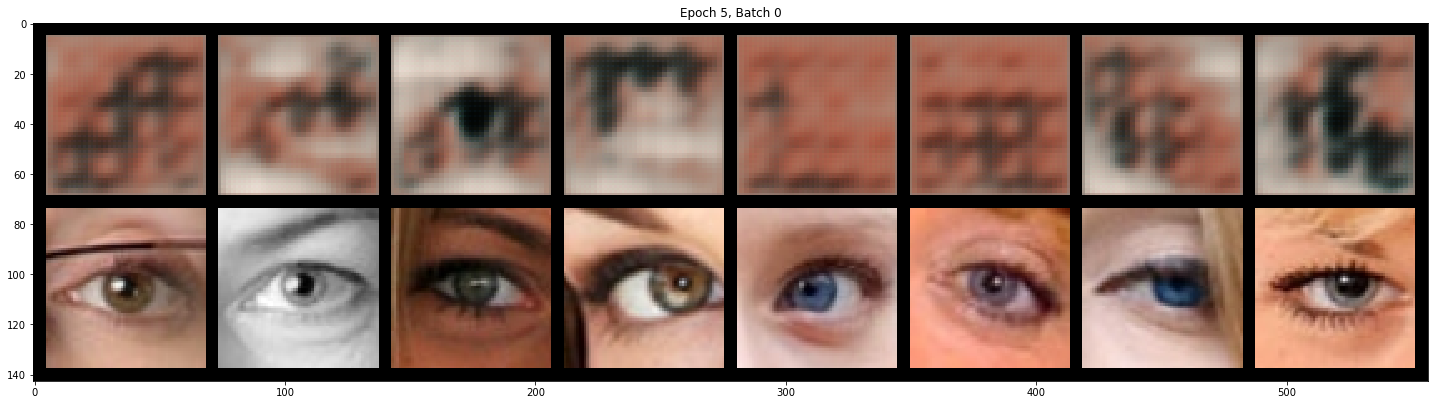

 80%|████████  | 4/5 [05:58<01:20, 80.31s/e, lossC=-1.48, lossG=0.693] 

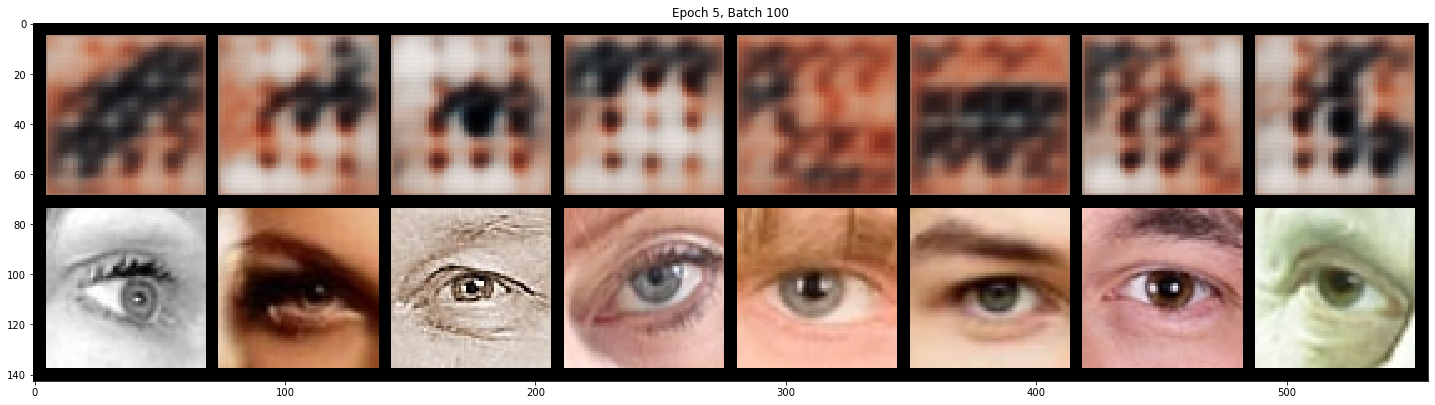

100%|██████████| 5/5 [06:22<00:00, 76.49s/e, lossC=-.335, lossG=0.219]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
from time import sleep

# Hyperparams (from the WGAN Paper)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5  # 2e-4 from Paper
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

transforms = transforms.Compose(
    [
    	transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
     	transforms.ToTensor(),
     	transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]), 
		]
)

# dataset = datasets.MNIST(root="./../_datasets/dataset/", train=True, transform=transforms, download=True)
dataset = datasets.ImageFolder(root="./../_datasets/eyes/", transform=transforms)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

fixed_noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)

gen.train()
critic.train()

# Train Loop
with trange(NUM_EPOCHS, unit="e") as tepoch:
    for epoch in tepoch:
        for batch_idx, (real, _) in enumerate(loader):
            real = real.to(device)
            
            # Train Discriminator
            for _ in range(CRITIC_ITERATIONS):
                noise = torch.randn(BATCH_SIZE, Z_DIM, 1 ,1).to(device)
                fake = gen(noise)
                critic_real = critic(real).reshape(-1)
                critic_fake = critic(fake).reshape(-1)
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
                critic.zero_grad()
                loss_critic.backward(retain_graph=True) 
                opt_critic.step()
                
                for p in critic.parameters():
                    p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
                    
            # Train Generator: min -E[critic(gen_fake)]
            output = critic(fake).reshape(-1)
            loss_gen = -torch.mean(output)
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
            
            tepoch.set_postfix(lossC=loss_critic.item(),lossG=loss_gen.item())
            
            # Printout
            if batch_idx % 100 == 0:
                with torch.no_grad():
                    fake = gen(fixed_noise).reshape(-1, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
                    show_images(torch.cat((fake[:8], real[:8]), 0), epoch, batch_idx)
                    
